In [ ]:
!pip install transformers datasets scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Esto instalará las librerías:

transformers: Para usar los modelos preentrenados como BERT.
datasets: Para manejar y procesar datasets de manera eficiente.
torch: La librería de PyTorch para el entrenamiento del modelo.
scikit-learn: Para tareas de evaluación y métricas, como la matriz de confusión.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertForSequenceClassification, BertTokenizer, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score


Paso 2: Preprocesar y preparar el dataset
2.3. Preprocesar los datos
Vamos a convertir las etiquetas de sentimiento y tema en valores numéricos. Además, vamos a preparar el dataset para que pueda ser utilizado con el modelo.

Sentimiento:

alegría = 0
asco = 1
ira = 2
miedo = 3
sorpresa = 4
tristeza = 5
Tema:

política = 0
migración = 1
ninguno = 2

In [ ]:
# Cargar el dataset CSV
df = pd.read_csv('dataset1.csv')  # Reemplaza 'tu_dataset.csv' con el nombre de tu archivo



In [ ]:
# Verificar las primeras filas del dataset antes del mapeo
print("Primeras filas del dataset de entrenamiento antes del mapeo:")
print(df.head())

# Mapeo de las etiquetas de sentimiento y tema
sentimiento_mapping = {'alegria': 0, 'asco': 1, 'ira': 2, 'miedo': 3, 'sorpresa': 4, 'tristeza': 5}
tema_mapping = {'politica': 0, 'migracion': 1, 'ninguno': 2}

# Convertir las etiquetas en números
df['sentimiento'] = df['sentimiento'].map(sentimiento_mapping)
df['tema'] = df['tema'].map(tema_mapping)

# Verificar las primeras filas del dataset después del mapeo
print("Primeras filas del dataset de entrenamiento después del mapeo:")
print(df.head())

# Verificar los valores nulos después del mapeo
print("Valores nulos en el dataset después del mapeo:")
print(df[['sentimiento', 'tema']].isnull().sum())

Primeras filas del dataset de entrenamiento antes del mapeo:
                                             comment sentimiento      tema
0  la politica venezolana paso de ser un chiste a...         ira  politica
1  lo que le hicieron a raul isaias baduel quedar...         ira  politica
2  respeten que gente de poca mente superenlo no ...         ira  politica
3  lo dice un dinosaurio de la politica venezolan...         ira  politica
4  que insistencia la de caramelo de colaborar co...         ira  politica
Primeras filas del dataset de entrenamiento después del mapeo:
                                             comment  sentimiento  tema
0  la politica venezolana paso de ser un chiste a...          2.0   0.0
1  lo que le hicieron a raul isaias baduel quedar...          2.0   0.0
2  respeten que gente de poca mente superenlo no ...          2.0   0.0
3  lo dice un dinosaurio de la politica venezolan...          2.0   0.0
4  que insistencia la de caramelo de colaborar co...          2.0 

Paso 3: Tokenización
3.1. Tokenizar los comentarios
Usaremos el tokenizador preentrenado de BERT para tokenizar los comentarios en tu dataset. Esto convierte los comentarios en números y los ajusta para que puedan ser procesados por el modelo de manera eficiente.

In [ ]:
# Eliminar filas con valores nulos en 'sentimiento' o 'tema'
df = df.dropna(subset=['sentimiento', 'tema'])

# Verificar que las filas con valores nulos hayan sido eliminadas
print("Primeras filas del dataset después de eliminar los valores nulos:")
print(df.head())

# Verificar nuevamente los valores nulos
print("Valores nulos en el dataset después de eliminar los valores nulos:")
print(df[['sentimiento', 'tema']].isnull().sum())


Primeras filas del dataset después de eliminar los valores nulos:
                                             comment  sentimiento  tema
0  la politica venezolana paso de ser un chiste a...          2.0   0.0
1  lo que le hicieron a raul isaias baduel quedar...          2.0   0.0
2  respeten que gente de poca mente superenlo no ...          2.0   0.0
3  lo dice un dinosaurio de la politica venezolan...          2.0   0.0
4  que insistencia la de caramelo de colaborar co...          2.0   0.0
Valores nulos en el dataset después de eliminar los valores nulos:
sentimiento    0
tema           0
dtype: int64


Paso 4: Configuración y entrenamiento del modelo
4.1. Configurar el modelo de BERT
Vamos a cargar un modelo preentrenado de BERT para clasificación. Dado que estamos trabajando en un problema de clasificación múltiple (sentimiento y tema), configuraremos el modelo para que realice dos tareas: clasificación de sentimiento (5 clases) y clasificación de tema (3 clases).

In [ ]:
print(df[:10])

                                             comment  sentimiento  tema
0  la politica venezolana paso de ser un chiste a...          2.0   0.0
1  lo que le hicieron a raul isaias baduel quedar...          2.0   0.0
2  respeten que gente de poca mente superenlo no ...          2.0   0.0
3  lo dice un dinosaurio de la politica venezolan...          2.0   0.0
4  que insistencia la de caramelo de colaborar co...          2.0   0.0
5  1994 muere mercedes carvajal de arocha conocid...          5.0   0.0
6  no me interesa lo que dice por que no estoy ha...          0.0   0.0
7  que va yo solo creo a los que hacen politica a...          2.0   0.0
8  eso es costumbre venezolana y colombiana con a...          2.0   0.0
9  yo amaba a venezuela soy 5ta generacion venezo...          5.0   0.0


In [ ]:

df['sentimiento'] = df['sentimiento'].astype(int)
df['tema'] = df['tema'].astype(int)
print(df.head())

                                             comment  sentimiento  tema
0  la politica venezolana paso de ser un chiste a...            2     0
1  lo que le hicieron a raul isaias baduel quedar...            2     0
2  respeten que gente de poca mente superenlo no ...            2     0
3  lo dice un dinosaurio de la politica venezolan...            2     0
4  que insistencia la de caramelo de colaborar co...            2     0


Configurar los parámetros de entrenamiento
Ahora vamos a configurar los parámetros de entrenamiento, como el número de épocas, el tamaño del batch, y otras opciones como el learning rate.

In [ ]:
# Verificar nuevamente los valores nulos
print("Valores nulos en el dataset después de eliminar los valores nulos:")
print(df[['sentimiento', 'tema']].isnull().sum())



Valores nulos en el dataset después de eliminar los valores nulos:
sentimiento    0
tema           0
dtype: int64


evaluation_strategy="epoch": Evaluamos el modelo al final de cada época.
save_strategy="epoch": Guardamos el modelo al final de cada época para asegurarnos de que el mejor modelo se guarde y se cargue al final.
load_best_model_at_end=True: El modelo guardado que tiene el mejor rendimiento en el conjunto de validación será el que se cargue al final.

In [ ]:
print(df[:5])



                                             comment  sentimiento  tema
0  la politica venezolana paso de ser un chiste a...            2     0
1  lo que le hicieron a raul isaias baduel quedar...            2     0
2  respeten que gente de poca mente superenlo no ...            2     0
3  lo dice un dinosaurio de la politica venezolan...            2     0
4  que insistencia la de caramelo de colaborar co...            2     0


In [ ]:
# Dividir el dataset en entrenamiento y validación
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Convertir los DataFrames a datasets de Hugging Face
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)


In [ ]:
# Cargar el modelo y tokenizador BERT para clasificación
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=9)  # 9 etiquetas (6 sentimientos + 3 temas)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
# Función de preprocesamiento
def preprocess_function(examples):
    tokenized_inputs = tokenizer(examples['comment'], padding=True, truncation=True, max_length=512)
    tokenized_inputs['labels'] = examples['sentimiento']  # Etiqueta de sentimiento
    tokenized_inputs['tema_labels'] = examples['tema']  # Etiqueta de tema
    return tokenized_inputs

# Aplicar la función de preprocesamiento
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/4304 [00:00<?, ? examples/s]

Map:   0%|          | 0/1076 [00:00<?, ? examples/s]

In [ ]:
# Definir los parámetros de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=500,
    report_to="none"  # Desactivar cualquier intento de logging con W&B
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Función de cálculo de métricas
def compute_metrics(pred):
    labels = pred.label_ids
    sentimiento_preds = np.argmax(pred.predictions[:, :6], axis=1)
    tema_preds = np.argmax(pred.predictions[:, 6:], axis=1)
    sentimiento_accuracy = accuracy_score(labels, sentimiento_preds)
    tema_accuracy = accuracy_score(pred.label_ids, tema_preds)
    return {"sentimiento_accuracy": sentimiento_accuracy, "tema_accuracy": tema_accuracy}

# Crear el objeto Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

<ipython-input-23-bba050df1319>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Sentimiento Accuracy,Tema Accuracy
1,1.002500,0.816651,0.687732,0.379182
2,0.803200,0.779951,0.698885,0.488848
3,0.596700,0.902884,0.721190,0.131970


Epoch,Training Loss,Validation Loss,Sentimiento Accuracy,Tema Accuracy
1,1.002500,0.816651,0.687732,0.379182
2,0.803200,0.779951,0.698885,0.488848
3,0.596700,0.902884,0.721190,0.131970


In [ ]:
trainer.save_model('./modelo_entrenado_bert')

NameError: name 'trainer' is not defined

In [ ]:
def inferir_sentimiento_tema(texto):
    inputs = tokenizer(texto, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    sentimiento_pred = np.argmax(outputs.logits[:, :6].detach().numpy())
    sentimiento_label = list(sentimiento_mapping.keys())[list(sentimiento_mapping.values()).index(sentimiento_pred)]
    tema_probs = outputs.logits[:, 6:].softmax(dim=1).detach().numpy()[0]
    tema_labels = list(tema_mapping.keys())
    tema_percentages = {label: prob * 100 for label, prob in zip(tema_labels, tema_probs)}
    print(f"Sentimiento: {sentimiento_pred} [{sentimiento_label}]")
    print(f"tema: migración {tema_percentages['migracion']:.0f}% política {tema_percentages['politica']:.0f}% ninguno {tema_percentages['ninguno']:.0f}%")

# Ejemplo de uso:
texto = "Odio el país, me quiero ir"
inferir_sentimiento_tema(texto)

NameError: name 'tokenizer' is not defined

In [ ]:
import os
import zipfile

def comprimir_carpeta(carpeta_origen, archivo_zip):
    """
    Comprime una carpeta en un archivo .zip.
    """
    with zipfile.ZipFile(archivo_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, archivos in os.walk(carpeta_origen):
            for archivo in archivos:
                ruta_archivo = os.path.join(root, archivo)
                ruta_relativa = os.path.relpath(ruta_archivo, carpeta_origen)
                zipf.write(ruta_archivo, ruta_relativa)

# Llamar a la función para comprimir la carpeta del modelo.
carpeta_modelo = './modelo_entrenado'  # Reemplaza con la ruta de tu modelo
comprimir_carpeta(carpeta_modelo, 'modelo_entrenado.zip')

print("Modelo comprimido y guardado en 'modelo_entrenado.zip'")

Modelo comprimido y guardado en 'modelo_entrenado.zip'


In [ ]:
# Guardar el modelo y el tokenizador
model.save_pretrained('./modelo_entrenado')
tokenizer.save_pretrained('./modelo_entrenado')


NameError: name 'model' is not defined

In [ ]:
from google.colab import files
import shutil

# Comprimir el modelo guardado en un archivo zip
shutil.make_archive('/content/modelo_entrenado', 'zip', './modelo_entrenado')

# Descargar el archivo zip
files.download('/content/modelo_entrenado.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Comprimir la carpeta del modelo
!zip -r modelo_entrenado.zip modelo_entrenado

from google.colab import files

# Descargar el archivo zip
files.download("modelo_entrenado.zip")

  adding: modelo_entrenado/ (stored 0%)
  adding: modelo_entrenado/tokenizer_config.json (deflated 75%)
  adding: modelo_entrenado/special_tokens_map.json (deflated 42%)
  adding: modelo_entrenado/model.safetensors (deflated 7%)
  adding: modelo_entrenado/training_args.bin (deflated 52%)
  adding: modelo_entrenado/vocab.txt (deflated 45%)
  adding: modelo_entrenado/config.json (deflated 58%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (3).

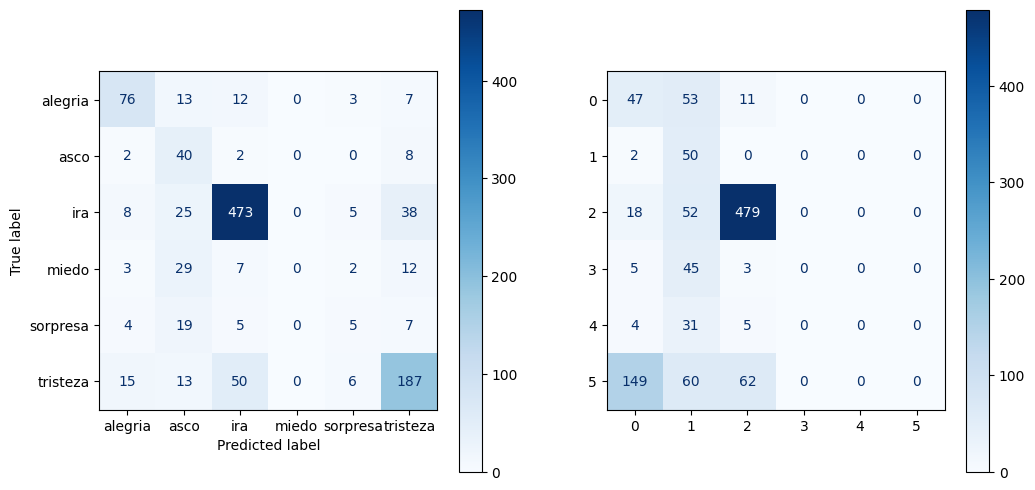

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Obtener las predicciones y las etiquetas verdaderas
predictions = trainer.predict(val_dataset)
pred_sentimiento = np.argmax(predictions.predictions[:, :6], axis=1)
true_sentimiento = predictions.label_ids

# Para el tema
pred_tema = np.argmax(predictions.predictions[:, 6:], axis=1)
true_tema = predictions.label_ids

# Matriz de confusión para sentimiento
cm_sentimiento = confusion_matrix(true_sentimiento, pred_sentimiento)
disp_sentimiento = ConfusionMatrixDisplay(confusion_matrix=cm_sentimiento, display_labels=list(sentimiento_mapping.keys()))

# Matriz de confusión para tema
cm_tema = confusion_matrix(true_tema, pred_tema)
disp_tema = ConfusionMatrixDisplay(confusion_matrix=cm_tema, display_labels=list(tema_mapping.keys()))

# Mostrar las matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
disp_sentimiento.plot(ax=axes[0], cmap='Blues')
disp_tema.plot(ax=axes[1], cmap='Blues')

# Mostrar el gráfico
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful